In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [15]:
train = pd.read_csv("/Users/jennyprasad/Downloads/train.csv")
features = pd.read_csv("/Users/jennyprasad/Downloads/features.csv")
stores = pd.read_csv("/Users/jennyprasad/Downloads/stores.csv")

df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(stores, on="Store", how="left")

# Convert date
df["Date"] = pd.to_datetime(df["Date"])

# Sort
df = df.sort_values("Date")

# Aggregate weekly sales across all stores
sales_df = df.groupby("Date")["Weekly_Sales"].sum().reset_index()

# Normalize sales
scaler = MinMaxScaler()
sales_df["Scaled_Sales"] = scaler.fit_transform(sales_df[["Weekly_Sales"]])

In [16]:
def create_sequences(data, input_len=30, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - input_len - forecast_steps + 1):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+forecast_steps])
    return np.array(X), np.array(y)

In [17]:
def run_lstm(input_data, input_len=30, forecast_steps=1):
    X, y = create_sequences(input_data, input_len, forecast_steps)

    # Reshape input for LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build model
    model = Sequential()
    model.add(LSTM(64, activation="relu", input_shape=(input_len, 1)))
    model.add(Dense(forecast_steps))
    model.compile(optimizer="adam", loss="mse")

    # Train
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation (global)
    mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

    print(f"Forecast t+1 to t+{forecast_steps} - MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # Per-step metrics
    for step in range(forecast_steps):
        step_mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
        step_rmse = np.sqrt(mean_squared_error(y_test[:, step], y_pred[:, step]))
        print(f"  ↳ t+{step+1}: MAE = {step_mae:.4f}, RMSE = {step_rmse:.4f}")

    return mae, rmse, y_test, y_pred


In [18]:
# Use scaled values
series = sales_df["Scaled_Sales"].values

# Predict next 1 week
mae_1, rmse_1, y_test_1, y_pred_1 = run_lstm(series, input_len=30, forecast_steps=1)
mae_3, rmse_3, y_test_3, y_pred_3 = run_lstm(series, input_len=30, forecast_steps=3)

# Predict next 7 weeks
mae_7, rmse_7, y_test_7, y_pred_7 = run_lstm(series, input_len=30, forecast_steps=7)

# Compare results
print("\nFinal Comparison:")
print(f"t+1 Prediction → MAE: {mae_1:.4f}, RMSE: {rmse_1:.4f}")
print(f"t+7 Prediction → MAE: {mae_7:.4f}, RMSE: {rmse_7:.4f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+1 - MAE: 0.0366 | RMSE: 0.0444
  ↳ t+1: MAE = 0.0366, RMSE = 0.0444


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Forecast t+1 to t+3 - MAE: 0.0462 | RMSE: 0.0563
  ↳ t+1: MAE = 0.0496, RMSE = 0.0594
  ↳ t+2: MAE = 0.0338, RMSE = 0.0423
  ↳ t+3: MAE = 0.0551, RMSE = 0.0648


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Forecast t+1 to t+7 - MAE: 0.0348 | RMSE: 0.0437
  ↳ t+1: MAE = 0.0334, RMSE = 0.0429
  ↳ t+2: MAE = 0.0381, RMSE = 0.0461
  ↳ t+3: MAE = 0.0313, RMSE = 0.0423
  ↳ t+4: MAE = 0.0329, RMSE = 0.0419
  ↳ t+5: MAE = 0.0343, RMSE = 0.0433
  ↳ t+6: MAE = 0.0375, RMSE = 0.0455
  ↳ t+7: MAE = 0.0358, RMSE = 0.0441

Final Comparison:
t+1 Prediction → MAE: 0.0366, RMSE: 0.0444
t+7 Prediction → MAE: 0.0348, RMSE: 0.0437


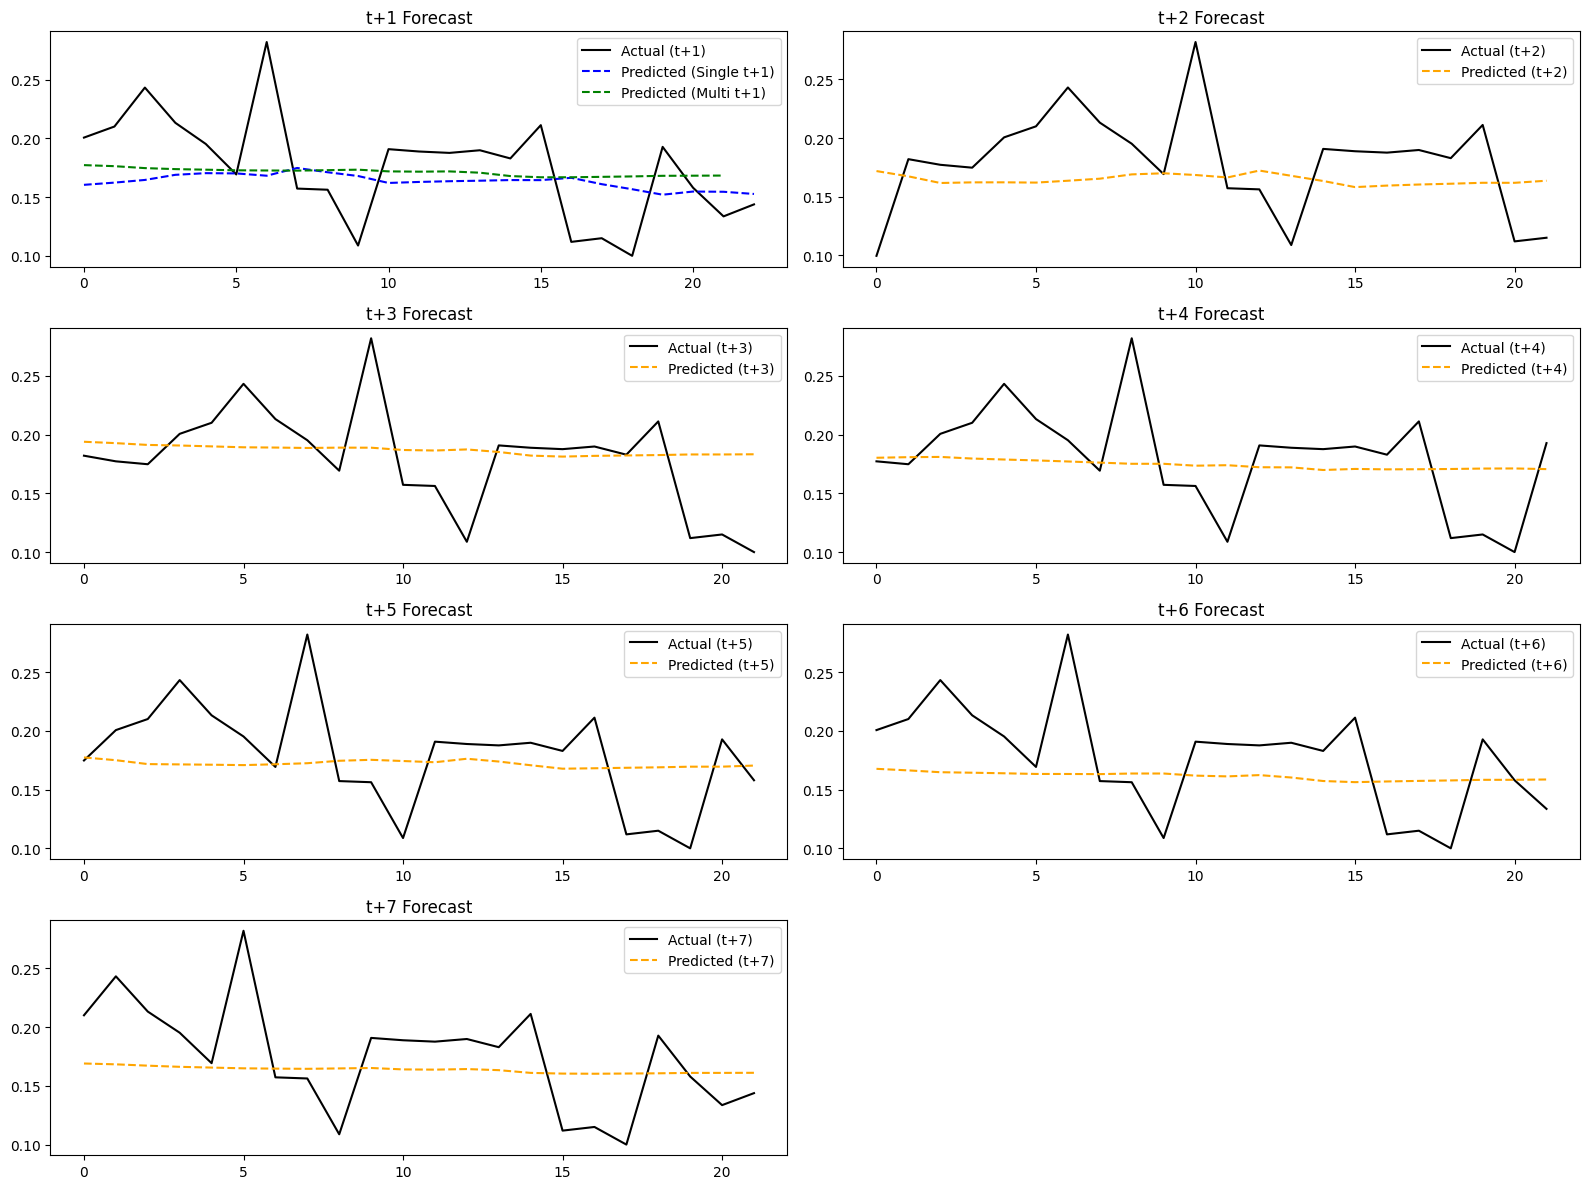

In [19]:
import matplotlib.pyplot as plt

num_samples_to_plot = 50

plt.figure(figsize=(16, 12))

# Plot t+1: both single-step and from the multi-step
plt.subplot(4, 2, 1)
plt.plot(y_test_1[:num_samples_to_plot, 0], label="Actual (t+1)", color="black")
plt.plot(y_pred_1[:num_samples_to_plot, 0], label="Predicted (Single t+1)", linestyle="--", color="blue")
plt.plot(y_pred_7[:num_samples_to_plot, 0], label="Predicted (Multi t+1)", linestyle="--", color="green")
plt.title("t+1 Forecast")
plt.legend()

# Plot t+2 to t+7 (multi-step predictions only)
for i in range(1, 7):
    plt.subplot(4, 2, i+1)
    plt.plot(y_test_7[:num_samples_to_plot, i], label=f"Actual (t+{i+1})", color="black")
    plt.plot(y_pred_7[:num_samples_to_plot, i], label=f"Predicted (t+{i+1})", linestyle="--", color="orange")
    plt.title(f"t+{i+1} Forecast")
    plt.legend()

plt.tight_layout()
plt.show()


In [20]:
#hyperparamter testing

Running → input_len=15, units=64, optimizer=adam, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+7 - MAE: 0.0424 | RMSE: 0.0523
  ↳ t+1: MAE = 0.0437, RMSE = 0.0572
  ↳ t+2: MAE = 0.0374, RMSE = 0.0511
  ↳ t+3: MAE = 0.0367, RMSE = 0.0450
  ↳ t+4: MAE = 0.0505, RMSE = 0.0581
  ↳ t+5: MAE = 0.0419, RMSE = 0.0500
  ↳ t+6: MAE = 0.0452, RMSE = 0.0530
  ↳ t+7: MAE = 0.0416, RMSE = 0.0503
Running → input_len=15, units=64, optimizer=adam, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+7 - MAE: 0.0370 | RMSE: 0.0491
  ↳ t+1: MAE = 0.0397, RMSE = 0.0541
  ↳ t+2: MAE = 0.0359, RMSE = 0.0515
  ↳ t+3: MAE = 0.0335, RMSE = 0.0441
  ↳ t+4: MAE = 0.0347, RMSE = 0.0443
  ↳ t+5: MAE = 0.0438, RMSE = 0.0565
  ↳ t+6: MAE = 0.0379, RMSE = 0.0490
  ↳ t+7: MAE = 0.0332, RMSE = 0.0424
Running → input_len=15, units=64, optimizer=rmsprop, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Forecast t+1 to t+7 - MAE: 0.0461 | RMSE: 0.0583
  ↳ t+1: MAE = 0.0417, RMSE = 0.0554
  ↳ t+2: MAE = 0.0645, RMSE = 0.0784
  ↳ t+3: MAE = 0.0516, RMSE = 0.0628
  ↳ t+4: MAE = 0.0392, RMSE = 0.0466
  ↳ t+5: MAE = 0.0465, RMSE = 0.0589
  ↳ t+6: MAE = 0.0459, RMSE = 0.0565
  ↳ t+7: MAE = 0.0330, RMSE = 0.0424
Running → input_len=15, units=64, optimizer=rmsprop, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0348 | RMSE: 0.0472
  ↳ t+1: MAE = 0.0418, RMSE = 0.0557
  ↳ t+2: MAE = 0.0367, RMSE = 0.0516
  ↳ t+3: MAE = 0.0331, RMSE = 0.0439
  ↳ t+4: MAE = 0.0332, RMSE = 0.0450
  ↳ t+5: MAE = 0.0321, RMSE = 0.0454
  ↳ t+6: MAE = 0.0346, RMSE = 0.0437
  ↳ t+7: MAE = 0.0321, RMSE = 0.0432
Running → input_len=15, units=128, optimizer=adam, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Forecast t+1 to t+7 - MAE: 0.0376 | RMSE: 0.0484
  ↳ t+1: MAE = 0.0355, RMSE = 0.0511
  ↳ t+2: MAE = 0.0503, RMSE = 0.0611
  ↳ t+3: MAE = 0.0364, RMSE = 0.0448
  ↳ t+4: MAE = 0.0366, RMSE = 0.0451
  ↳ t+5: MAE = 0.0406, RMSE = 0.0491
  ↳ t+6: MAE = 0.0311, RMSE = 0.0424
  ↳ t+7: MAE = 0.0328, RMSE = 0.0424
Running → input_len=15, units=128, optimizer=adam, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0352 | RMSE: 0.0473
  ↳ t+1: MAE = 0.0366, RMSE = 0.0514
  ↳ t+2: MAE = 0.0373, RMSE = 0.0512
  ↳ t+3: MAE = 0.0350, RMSE = 0.0442
  ↳ t+4: MAE = 0.0401, RMSE = 0.0529
  ↳ t+5: MAE = 0.0329, RMSE = 0.0450
  ↳ t+6: MAE = 0.0314, RMSE = 0.0421
  ↳ t+7: MAE = 0.0329, RMSE = 0.0426
Running → input_len=15, units=128, optimizer=rmsprop, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0376 | RMSE: 0.0481
  ↳ t+1: MAE = 0.0415, RMSE = 0.0556
  ↳ t+2: MAE = 0.0387, RMSE = 0.0529
  ↳ t+3: MAE = 0.0425, RMSE = 0.0500
  ↳ t+4: MAE = 0.0346, RMSE = 0.0446
  ↳ t+5: MAE = 0.0359, RMSE = 0.0449
  ↳ t+6: MAE = 0.0347, RMSE = 0.0435
  ↳ t+7: MAE = 0.0353, RMSE = 0.0441
Running → input_len=15, units=128, optimizer=rmsprop, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0360 | RMSE: 0.0476
  ↳ t+1: MAE = 0.0360, RMSE = 0.0510
  ↳ t+2: MAE = 0.0382, RMSE = 0.0526
  ↳ t+3: MAE = 0.0337, RMSE = 0.0458
  ↳ t+4: MAE = 0.0381, RMSE = 0.0459
  ↳ t+5: MAE = 0.0346, RMSE = 0.0448
  ↳ t+6: MAE = 0.0382, RMSE = 0.0490
  ↳ t+7: MAE = 0.0329, RMSE = 0.0433
Running → input_len=30, units=64, optimizer=adam, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0354 | RMSE: 0.0449
  ↳ t+1: MAE = 0.0352, RMSE = 0.0437
  ↳ t+2: MAE = 0.0324, RMSE = 0.0433
  ↳ t+3: MAE = 0.0334, RMSE = 0.0434
  ↳ t+4: MAE = 0.0336, RMSE = 0.0435
  ↳ t+5: MAE = 0.0389, RMSE = 0.0477
  ↳ t+6: MAE = 0.0342, RMSE = 0.0429
  ↳ t+7: MAE = 0.0405, RMSE = 0.0491
Running → input_len=30, units=64, optimizer=adam, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+7 - MAE: 0.0341 | RMSE: 0.0443
  ↳ t+1: MAE = 0.0332, RMSE = 0.0455
  ↳ t+2: MAE = 0.0325, RMSE = 0.0437
  ↳ t+3: MAE = 0.0308, RMSE = 0.0409
  ↳ t+4: MAE = 0.0317, RMSE = 0.0419
  ↳ t+5: MAE = 0.0364, RMSE = 0.0450
  ↳ t+6: MAE = 0.0357, RMSE = 0.0437
  ↳ t+7: MAE = 0.0382, RMSE = 0.0489
Running → input_len=30, units=64, optimizer=rmsprop, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Forecast t+1 to t+7 - MAE: 0.0668 | RMSE: 0.0811
  ↳ t+1: MAE = 0.0373, RMSE = 0.0456
  ↳ t+2: MAE = 0.0407, RMSE = 0.0526
  ↳ t+3: MAE = 0.0747, RMSE = 0.0832
  ↳ t+4: MAE = 0.0551, RMSE = 0.0630
  ↳ t+5: MAE = 0.1026, RMSE = 0.1105
  ↳ t+6: MAE = 0.1176, RMSE = 0.1247
  ↳ t+7: MAE = 0.0399, RMSE = 0.0507
Running → input_len=30, units=64, optimizer=rmsprop, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0439 | RMSE: 0.0553
  ↳ t+1: MAE = 0.0334, RMSE = 0.0424
  ↳ t+2: MAE = 0.0484, RMSE = 0.0596
  ↳ t+3: MAE = 0.0364, RMSE = 0.0446
  ↳ t+4: MAE = 0.0317, RMSE = 0.0416
  ↳ t+5: MAE = 0.0327, RMSE = 0.0417
  ↳ t+6: MAE = 0.0669, RMSE = 0.0760
  ↳ t+7: MAE = 0.0579, RMSE = 0.0693
Running → input_len=30, units=128, optimizer=adam, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0369 | RMSE: 0.0458
  ↳ t+1: MAE = 0.0455, RMSE = 0.0531
  ↳ t+2: MAE = 0.0347, RMSE = 0.0442
  ↳ t+3: MAE = 0.0363, RMSE = 0.0451
  ↳ t+4: MAE = 0.0325, RMSE = 0.0423
  ↳ t+5: MAE = 0.0368, RMSE = 0.0454
  ↳ t+6: MAE = 0.0367, RMSE = 0.0451
  ↳ t+7: MAE = 0.0357, RMSE = 0.0442
Running → input_len=30, units=128, optimizer=adam, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Forecast t+1 to t+7 - MAE: 0.0397 | RMSE: 0.0497
  ↳ t+1: MAE = 0.0324, RMSE = 0.0422
  ↳ t+2: MAE = 0.0459, RMSE = 0.0535
  ↳ t+3: MAE = 0.0469, RMSE = 0.0542
  ↳ t+4: MAE = 0.0317, RMSE = 0.0421
  ↳ t+5: MAE = 0.0463, RMSE = 0.0567
  ↳ t+6: MAE = 0.0344, RMSE = 0.0461
  ↳ t+7: MAE = 0.0404, RMSE = 0.0510
Running → input_len=30, units=128, optimizer=rmsprop, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0354 | RMSE: 0.0460
  ↳ t+1: MAE = 0.0349, RMSE = 0.0471
  ↳ t+2: MAE = 0.0319, RMSE = 0.0437
  ↳ t+3: MAE = 0.0311, RMSE = 0.0434
  ↳ t+4: MAE = 0.0372, RMSE = 0.0452
  ↳ t+5: MAE = 0.0387, RMSE = 0.0500
  ↳ t+6: MAE = 0.0400, RMSE = 0.0477
  ↳ t+7: MAE = 0.0341, RMSE = 0.0449
Running → input_len=30, units=128, optimizer=rmsprop, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0347 | RMSE: 0.0456
  ↳ t+1: MAE = 0.0310, RMSE = 0.0425
  ↳ t+2: MAE = 0.0340, RMSE = 0.0436
  ↳ t+3: MAE = 0.0323, RMSE = 0.0434
  ↳ t+4: MAE = 0.0341, RMSE = 0.0463
  ↳ t+5: MAE = 0.0336, RMSE = 0.0426
  ↳ t+6: MAE = 0.0318, RMSE = 0.0438
  ↳ t+7: MAE = 0.0457, RMSE = 0.0556
Running → input_len=60, units=64, optimizer=adam, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Forecast t+1 to t+7 - MAE: 0.0706 | RMSE: 0.0857
  ↳ t+1: MAE = 0.0346, RMSE = 0.0441
  ↳ t+2: MAE = 0.0341, RMSE = 0.0448
  ↳ t+3: MAE = 0.0818, RMSE = 0.0905
  ↳ t+4: MAE = 0.0966, RMSE = 0.1047
  ↳ t+5: MAE = 0.1031, RMSE = 0.1110
  ↳ t+6: MAE = 0.1103, RMSE = 0.1185
  ↳ t+7: MAE = 0.0335, RMSE = 0.0441
Running → input_len=60, units=64, optimizer=adam, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+7 - MAE: 0.0986 | RMSE: 0.1101
  ↳ t+1: MAE = 0.1281, RMSE = 0.1347
  ↳ t+2: MAE = 0.0793, RMSE = 0.0909
  ↳ t+3: MAE = 0.1025, RMSE = 0.1122
  ↳ t+4: MAE = 0.0853, RMSE = 0.0964
  ↳ t+5: MAE = 0.0662, RMSE = 0.0796
  ↳ t+6: MAE = 0.0959, RMSE = 0.1060
  ↳ t+7: MAE = 0.1332, RMSE = 0.1377
Running → input_len=60, units=64, optimizer=rmsprop, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+7 - MAE: 0.0888 | RMSE: 0.1015
  ↳ t+1: MAE = 0.0675, RMSE = 0.0769
  ↳ t+2: MAE = 0.0999, RMSE = 0.1095
  ↳ t+3: MAE = 0.0514, RMSE = 0.0603
  ↳ t+4: MAE = 0.1308, RMSE = 0.1382
  ↳ t+5: MAE = 0.0765, RMSE = 0.0885
  ↳ t+6: MAE = 0.1237, RMSE = 0.1317
  ↳ t+7: MAE = 0.0718, RMSE = 0.0796
Running → input_len=60, units=64, optimizer=rmsprop, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0875 | RMSE: 0.1019
  ↳ t+1: MAE = 0.1169, RMSE = 0.1242
  ↳ t+2: MAE = 0.0989, RMSE = 0.1087
  ↳ t+3: MAE = 0.0590, RMSE = 0.0713
  ↳ t+4: MAE = 0.1104, RMSE = 0.1191
  ↳ t+5: MAE = 0.0341, RMSE = 0.0469
  ↳ t+6: MAE = 0.1286, RMSE = 0.1364
  ↳ t+7: MAE = 0.0646, RMSE = 0.0733
Running → input_len=60, units=128, optimizer=adam, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Forecast t+1 to t+7 - MAE: 0.0839 | RMSE: 0.0998
  ↳ t+1: MAE = 0.1537, RMSE = 0.1593
  ↳ t+2: MAE = 0.1197, RMSE = 0.1277
  ↳ t+3: MAE = 0.0473, RMSE = 0.0554
  ↳ t+4: MAE = 0.0645, RMSE = 0.0778
  ↳ t+5: MAE = 0.0863, RMSE = 0.0972
  ↳ t+6: MAE = 0.0495, RMSE = 0.0620
  ↳ t+7: MAE = 0.0666, RMSE = 0.0748
Running → input_len=60, units=128, optimizer=adam, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Forecast t+1 to t+7 - MAE: 0.0645 | RMSE: 0.0787
  ↳ t+1: MAE = 0.0766, RMSE = 0.0870
  ↳ t+2: MAE = 0.0627, RMSE = 0.0720
  ↳ t+3: MAE = 0.0435, RMSE = 0.0555
  ↳ t+4: MAE = 0.0513, RMSE = 0.0606
  ↳ t+5: MAE = 0.0721, RMSE = 0.0847
  ↳ t+6: MAE = 0.1157, RMSE = 0.1241
  ↳ t+7: MAE = 0.0300, RMSE = 0.0351
Running → input_len=60, units=128, optimizer=rmsprop, batch=16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Forecast t+1 to t+7 - MAE: 0.0856 | RMSE: 0.1019
  ↳ t+1: MAE = 0.0544, RMSE = 0.0628
  ↳ t+2: MAE = 0.0824, RMSE = 0.0939
  ↳ t+3: MAE = 0.1654, RMSE = 0.1716
  ↳ t+4: MAE = 0.0947, RMSE = 0.1047
  ↳ t+5: MAE = 0.0980, RMSE = 0.1077
  ↳ t+6: MAE = 0.0362, RMSE = 0.0458
  ↳ t+7: MAE = 0.0680, RMSE = 0.0764
Running → input_len=60, units=128, optimizer=rmsprop, batch=32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecast t+1 to t+7 - MAE: 0.0545 | RMSE: 0.0681
  ↳ t+1: MAE = 0.0326, RMSE = 0.0438
  ↳ t+2: MAE = 0.0350, RMSE = 0.0468
  ↳ t+3: MAE = 0.0853, RMSE = 0.0939
  ↳ t+4: MAE = 0.0866, RMSE = 0.0975
  ↳ t+5: MAE = 0.0341, RMSE = 0.0445
  ↳ t+6: MAE = 0.0616, RMSE = 0.0702
  ↳ t+7: MAE = 0.0465, RMSE = 0.0556


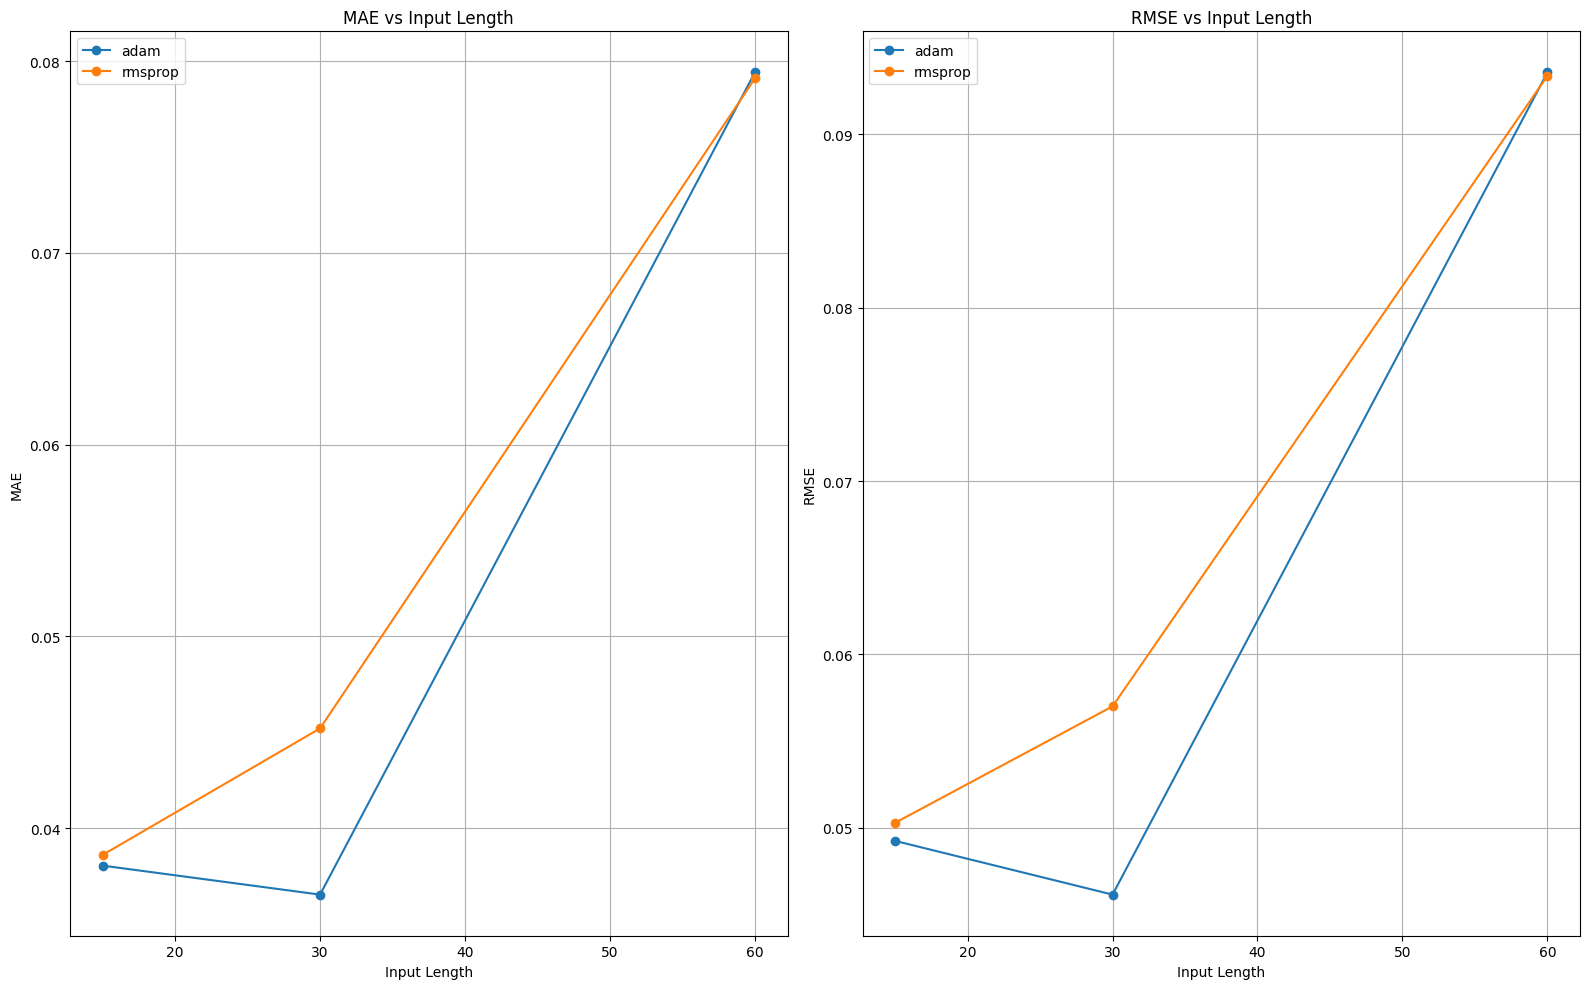

In [30]:
import matplotlib.pyplot as plt
import numpy as np

input_lens = [15, 30, 60]
lstm_units_list = [64, 128]     
optimizers = ['adam', 'rmsprop']  
batch_sizes = [16, 32]        

results = []


for input_len in input_lens:
    for units in lstm_units_list:
        for opt in optimizers:
            for batch in batch_sizes:
                print(f"Running → input_len={input_len}, units={units}, optimizer={opt}, batch={batch}")
                
                
                mae, rmse, _, _ = run_lstm(series, input_len=input_len, forecast_steps=7)
                
                
                results.append((input_len, units, opt, batch, mae, rmse))

optimizer_metrics = {opt: {'mae': [], 'rmse': []} for opt in optimizers}

for opt in optimizers:
    for input_len in input_lens:
        filtered = [(mae, rmse) for (inp, _, o, _, mae, rmse) in results if o == opt and inp == input_len]
        avg_mae = np.mean([mae for mae, _ in filtered])
        avg_rmse = np.mean([rmse for _, rmse in filtered])
        optimizer_metrics[opt]['mae'].append(avg_mae)
        optimizer_metrics[opt]['rmse'].append(avg_rmse)


fig, ax = plt.subplots(1, 2, figsize=(16, 10))


for opt in optimizers:
    ax[0].plot(input_lens, optimizer_metrics[opt]['mae'], marker='o', label=opt)
ax[0].set_title("MAE vs Input Length")
ax[0].set_xlabel("Input Length")
ax[0].set_ylabel("MAE")
ax[0].legend()
ax[0].grid(True)


for opt in optimizers:
    ax[1].plot(input_lens, optimizer_metrics[opt]['rmse'], marker='o', label=opt)
ax[1].set_title("RMSE vs Input Length")
ax[1].set_xlabel("Input Length")
ax[1].set_ylabel("RMSE")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
